In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pandas as pd
import argparse
from scipy.stats import chisquare

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.basemap import Basemap as Basemap

def get_KMeans(values, k):
    # Convert the list to a numpy array
    X = np.array(values).reshape(-1, 1)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k,n_init="auto",random_state=42)
    kmeans.fit(X)

    # Get the cluster labels
    cluster_labels = kmeans.labels_

    # Initialize lists for each cluster
    clusters = [[] for _ in range(k)]

    # Assign each value to its corresponding cluster
    for value, label in zip(values, cluster_labels):
        clusters[label].append(value)

    return sorted(clusters, key=lambda x: x[0])

def get_agglo(values, k):
  X = np.array(values).reshape(-1, 1)

  agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')

  # Fit the model to the data
  agg_clustering.fit(X)

  labels = agg_clustering.labels_

  return labels

def get_agglo_2d(x,y,k):
  X = np.array(x).reshape(-1, 1)
  Y = np.array(y).reshape(-1, 1)

  agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')

  # Fit the model to the data
  agg_clustering.fit(np.concatenate((X, Y), axis=1))

  labels = agg_clustering.labels_

  return labels

def find_elbow(x,y,dt):
  X = np.array(x).reshape(-1, 1)
  Y = np.array(y).reshape(-1, 1)

  agg_clustering = AgglomerativeClustering(n_clusters=None, linkage='ward',distance_threshold=dt)

  # Fit the model to the data
  agg_clustering.fit(np.concatenate((X, Y), axis=1))

  return agg_clustering.n_clusters_

137
137


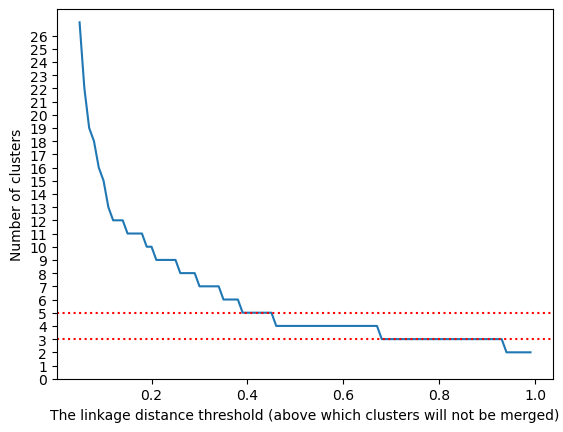

In [18]:
file = "NW_022145610.1_30779143_31460853"
# "12702886_13424367", 15422748_16793794
df1 = f"{file}_dim1.csv"
df2 = f"{file}_dim2.csv"
k=3
perc_explained = f"{file}_perc_explained.csv"

df1=pd.read_csv(df1)
df2=pd.read_csv(df2)
dim1=df1["dim1"].tolist()
dim2=df2["dim2"].tolist()

print(len(dim1))
print(len(dim2))

pe=pd.read_csv(perc_explained,names=["pes"])
pes_list=pe.pes.to_list()

dim=np.array(list(zip(dim1,dim2)))
pops=["BOD", "CAP", "FOG", "KIB", "LOM", "SAN", "TER"]
tpop=[]
for p in pops:
  if p != "CAP" and p!= "FOG":
    tpop.append([p] * 20)
  else:
    if p == "CAP":
      tpop.append([p] * 19)
    if p == "FOG":
      tpop.append([p] * 18)

pops=np.array([x for xs in tpop for x in xs]) #np.array([item for item in pops for _ in range(20)])
ind_id=np.array(list(range(1,len(pops)+1)))

NUM_CLUST=k

f_clusts=[]
for i in np.arange(0.05,1,0.01):
  f_clusts.append(find_elbow(dim1,dim2,i))

plt.plot(np.arange(0.05,1,0.01), f_clusts)
plt.axhline(3,color="red",linestyle=":")
plt.axhline(5,color="red",linestyle=":")
plt.ylim(0,max(f_clusts)+1)
plt.yticks(np.arange(0, max(f_clusts), step=1))
plt.ylabel("Number of clusters")
plt.xlabel("The linkage distance threshold (above which clusters will not be merged)")
plt.show()

75
57
5


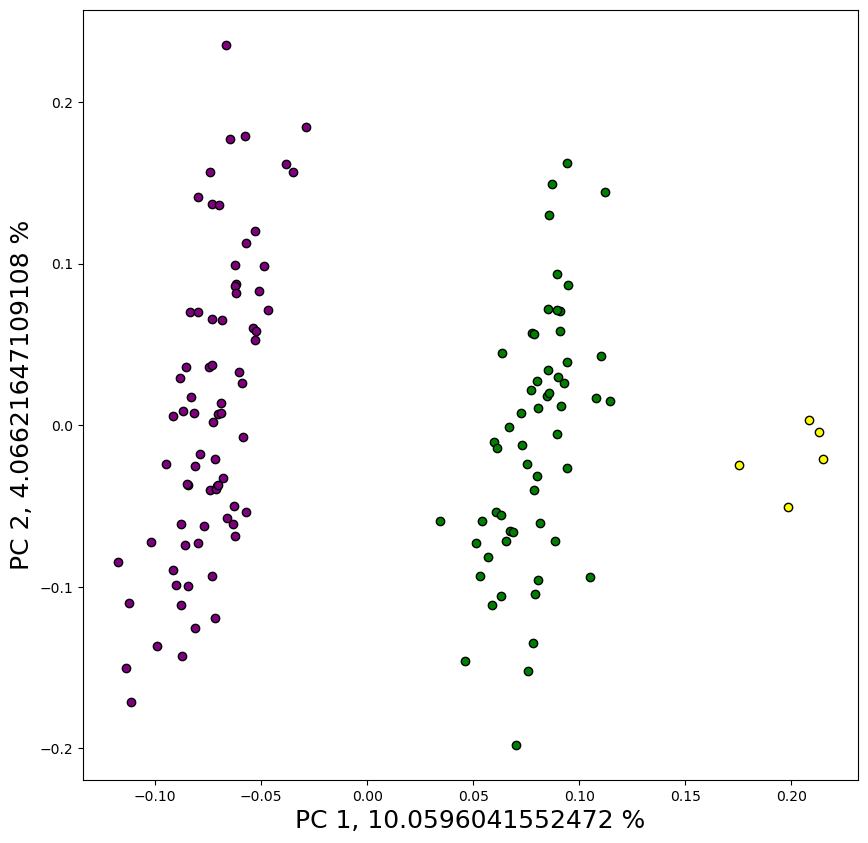

In [19]:
if NUM_CLUST == 3:
  clusts=get_agglo(dim1, NUM_CLUST)
else:
  clusts=get_agglo_2d(dim1,dim2,NUM_CLUST)

all_cols=["yellow","green","purple",'red', 'blue', 'orange', 'cyan', 'magenta', 'brown', 'lime']
p_colors= all_cols[:NUM_CLUST]
pca_colors = ["purple", "green","yellow"]

f, axs = plt.subplots(figsize=(10, 10))

pop_dic={}
id_dic={}
for c in range(NUM_CLUST):
  t=np.where(np.array(clusts) == c)[0]
  print(len(t))
  x=[i[0] for i in dim[t]]
  y=[i[1] for i in dim[t]]
  plt.scatter(x,y,edgecolors="black",c=pca_colors[c])
  avx=sum(x)/len(x)
  ids=pops[t]
  pop_dic[c]=[avx,ids]
  id_dic[c]=[avx,ind_id[t]]
plt.ylabel("PC 2, "+str(pes_list[1])+" %",fontsize=18)
plt.xlabel("PC 1, "+str(pes_list[0])+" %",fontsize=18)
plt.show()

In [14]:
colors=["yellow","green","purple",'red', 'blue', 'orange', 'cyan', 'magenta', 'brown', 'lime']
colors = plt.cm.tab10.colors #['blue', 'green', 'red', 'purple', 'orange', 'brown', 'magenta']
markers = ['o', 's', '^', 'D', '*', 'p', 'X']

coldic={}
c=0
for p in pops:
    if p not in coldic.keys():
        coldic[p] = colors[c]
        c+=1

mardic={}
c=0
for p in pops:
    if p not in mardic.keys():
        mardic[p] = markers[c]
        c+=1

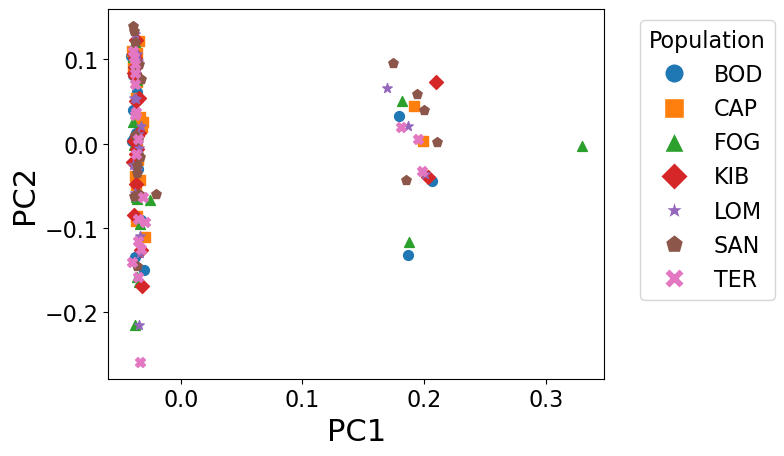

In [15]:
for i in range(len(df1["dim1"])):
    plt.scatter(df1["dim1"].to_list()[i], df2["dim2"].to_list()[i],color=coldic[pops[i]],marker=mardic[pops[i]],s=50)

legend_handles = []
c=0
for label, color in coldic.items():
    legend_handles.append(plt.Line2D([0], [0], marker=mardic[label], color='w', markerfacecolor=color, markersize=14, label=label))
    c+=1

# Add the legend to the plot
plt.legend(handles=legend_handles,loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=16,title="Population",title_fontsize=16)

plt.ylabel("PC2", fontsize=22)
plt.xlabel("PC1", fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig("figs/609_pop_PCA.pdf", format='pdf', bbox_inches='tight')